# Tutorial for MIRI post-pipeline contrast analyses 

In this notebook we will analyze the MIRI coronagraphy data on HIP 65426 b 
from the JWST ERS program on Direct Observations of Exoplanetary Systems, program 1386. 


<div class="alert alert-block alert-warning">
<b>Prerequisite:</b> This notebook assumes you have already ran the "Tutorial for MIRI data reductions" notebook. The output files  must be present from that reduction to be analyzed in this notebook.

</div>

## Setup and imports

In [1]:
import os
import pdb
import sys
import glob

import numpy as np
import astropy.io.fits as fits

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 14})

import spaceKLIP

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL


2023-08-03 15:52:20,860 - stpipe - INFO - NIRCam aperture name updated to NRCA1_FULL


[    stpipe:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRISS SIAF aperture name updated to NIS_CEN


2023-08-03 15:52:20,878 - stpipe - INFO - NIRISS SIAF aperture name updated to NIS_CEN


[    stpipe:INFO] NIRISS SIAF aperture name updated to NIS_CEN
[   webbpsf:INFO] MIRI SIAF aperture name updated to MIRIM_FULL


2023-08-03 15:52:20,968 - stpipe - INFO - MIRI SIAF aperture name updated to MIRIM_FULL


[    stpipe:INFO] MIRI SIAF aperture name updated to MIRIM_FULL


Note that currently the import of `webbpsf_ext` has a side effect of configuring extra verbose logging. We're not interested in that logging text, so let's quiet it. 

In [2]:
import webbpsf_ext
webbpsf_ext.setup_logging('WARN', verbose=False)

In [3]:
data_root = 'data_miri_hd65426'

## Re-read level 3 outputs into database 
Read in output files produced in the NIRCam coronagraph data reduction notebook. 

In [4]:
input_dir = os.path.join(data_root, 'klipsub')
    
fitsfiles = sorted(glob.glob(os.path.join(input_dir, "*KLmodes-all.fits")))

database = spaceKLIP.database.Database(output_dir=data_root)
database.read_jwst_s3_data(fitsfiles)

[spaceKLIP.database:INFO] --> Identified 2 concatenation(s)
[spaceKLIP.database:INFO]   --> Concatenation 1: JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140
 TYPE  EXP_TYPE DATAMODL TELESCOP  TARGPROP INSTRUME DETECTOR FILTER      CWAVEL          DWAVEL      PUPIL  CORONMSK NINTS EFFINTTM SUBARRAY  PIXSCALE    MODE  ANNULI SUBSECTS            KLMODES             BUNIT  BLURFWHM
------ -------- -------- -------- --------- -------- -------- ------ --------------- ---------------- ----- --------- ----- -------- -------- ---------- ------- ------ -------- ------------------------------ ------ --------
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  NONE 4QPM_1140    80 24.20768 MASK1140 110.917025 ADI+RDI      1        1 1,2,3,4,5,6,7,8,9,10,20,50,100 MJy/sr      nan
PYKLIP MIR_4QPM   STAGE3     JWST HIP-65426     MIRI MIRIMAGE F1140C 11.315651557554 0.60365321991656  NONE 4QPM_1140    80 24.20768 MASK1140 110.917025     ADI      1  

## Contrast Calculations

Here we use the analysistools module to measure contrast

### Preparation: Stellar Photometry Model

This requires an input giving the host star photometry, formatted as a  [Vizier](https://http://vizier.cds.unistra.fr) VOTable, or a simple text file with columns giving wavelenth in microns and flux in Jy.  The latter could be produced, for instance, from fitting a scaled version of a stellar atmosphere model to available photometry. 

We provide here examples of both kinds of file, provided by Aarynn Carter. _Only one is needed; we provide both purely as examples._

In [42]:
star_photometry_vot = 'HIP65426.vot'
star_photometry_txt = 'HIP65426A_sdf_phoenix_m+modbb_disk_r.txt'

In [44]:
import astropy

# Read in VOT version
vot_version = astropy.table.Table.read(star_photometry_vot)

# convert from freq to wl, just for plotting below.
vot_version['wavelength'] = (astropy.constants.c /  vot_version['sed_freq']).to(astropy.units.micron)

# Read in TXT version
txt_version = astropy.table.Table.read(star_photometry_txt,
                                       format='ascii',
                                       names=['wavelength', 'flux'])
txt_version.columns['wavelength'].unit = astropy.units.micron
txt_version.columns['flux'].unit = astropy.units.Jansky

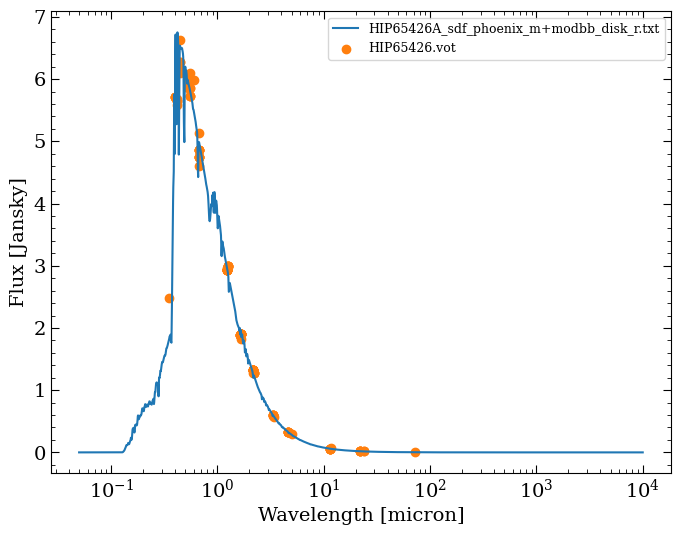

In [45]:
# plot, to show the two models are consistent

plt.semilogx(txt_version['wavelength'], txt_version['flux'], label='HIP65426A_sdf_phoenix_m+modbb_disk_r.txt',)
plt.scatter(vot_version['wavelength'], vot_version['sed_flux'], label='HIP65426.vot', color='C1')

plt.xlabel("Wavelength [micron]")
plt.ylabel("Flux [Jansky]")
plt.legend(fontsize=9)


In [46]:
# Initialize the spaceKLIP contrast estimation class.
analysistools = spaceKLIP.analysistools.AnalysisTools(database)


In [47]:
# Compute raw contrast.
analysistools.raw_contrast(star_photometry_txt)


[spaceKLIP.analysistools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140
[spaceKLIP.psf:INFO]   --> Generating WebbPSF model


NotImplementedError: 

## Extract measurements of the companion HD 65426 b


We need to know where the companion is. Using [whereistheplanet.org](https://whereistheplanet.org) for 2022 Aug 15:
```
RA Offset = 419.183 +/- 7.853 mas 
Dec Offset = -697.621 +/- 6.277 mas 
Separation = 813.875 +/- 6.388 mas 
PA = 149.014 +/- 0.547 deg 
Reference: Bowler et al. 2019
```
We also need to have a model for the stellar photometry for this step. We reuse the same file as above. 

This step also requires an uncertainty for the stellar photometry, parameterized `mstar_err`. This can be either a simple scalar estimate, like 0.05, or a dictionary giving uncertainty per JWST filter. 

In [6]:
dra = 0.41918
ddec = -0.6976
contrast = 1e-4

comp_estimate = (dra, ddec, contrast)

In [52]:
mstar_err = {'F250M': 0.054,
             'F300M': 0.046,
             'F356M': 0.048,
             'F410M': 0.051,
             'F444W': 0.054,
             'F1140C': 0.038,
             'F1550C': 0.072}

In [53]:
analysistools.extract_companions(companions=comp_estimate,
                                 starfile=star_photometry_txt,
                                 mstar_err = mstar_err)

[spaceKLIP.analysistools:INFO] --> Concatenation JWST_MIRI_MIRIMAGE_F1140C_NONE_4QPM_1140_MASK1140


AttributeError: 'MIRI_ext' object has no attribute '_update_coron_detector'

In [8]:
!mv /Users/mperrin/Downloads/HIP65426.vot .